# ANP PDF to Knowledge Graph & Policy Tree

**Objetivo**: Construir um pipeline completo de extração de texto de PDFs normativos da ANP, geração de Knowledge Graph orientado a decisão, projeção em Policy Graph (DAG decisório) e compilação final em árvore JSON compatível com classificador LATS.

**Outputs**:
- `artifacts/anp_text_corpus.jsonl` - Textos limpos por PDF
- `artifacts/anp_kg.graphml` - Knowledge Graph completo
- `artifacts/anp_policy.graphml` - Policy Graph (DAG decisório)
- `artifacts/anp_tree.json` - Árvore de decisão final

**Versão**: 1.0  
**Data**: 2025-12-20

## [0] Setup e Imports

### Dependências necessárias:

```bash
pip install pymupdf pdfplumber pytesseract pillow langchain langchain-experimental langchain-openai networkx pydantic python-dotenv tqdm matplotlib
```

**Nota**: Para OCR, é necessário ter o Tesseract instalado no sistema:
- Ubuntu/Debian: `sudo apt-get install tesseract-ocr tesseract-ocr-por`
- macOS: `brew install tesseract tesseract-lang`
- Windows: Download do instalador em https://github.com/UB-Mannheim/tesseract/wiki

In [67]:
# Imports padrão
import json
import re
import os
from pathlib import Path
from datetime import datetime
from typing import List, Dict, Any, Tuple, Optional
from collections import defaultdict, Counter
import hashlib

# Processamento de PDF e OCR
import fitz  # PyMuPDF
try:
    import pytesseract
    from PIL import Image
    OCR_AVAILABLE = True
except ImportError:
    OCR_AVAILABLE = False
    print("⚠️ pytesseract não disponível. OCR será desabilitado.")

# Grafo e análise
import networkx as nx
from tqdm.auto import tqdm

# LangChain e LLM
from dotenv import load_dotenv
from langchain_openai import AzureChatOpenAI
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_core.documents import Document

# Configuração
import warnings
warnings.filterwarnings('ignore')

print("✅ Imports carregados com sucesso")

⚠️ pytesseract não disponível. OCR será desabilitado.
✅ Imports carregados com sucesso


In [68]:
# Configuração de diretórios
PDF_DIR = Path("../padroes_anp")
ARTIFACTS_DIR = Path("../artifacts")

# Criar diretório de artefatos se não existir
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# Verificar se diretório de PDFs existe
if not PDF_DIR.exists():
    print(f"⚠️ Diretório {PDF_DIR} não encontrado. Criando...")
    PDF_DIR.mkdir(parents=True, exist_ok=True)
else:
    print(f"✅ Diretório de PDFs encontrado: {PDF_DIR}")

# Arquivos de saída
CORPUS_FILE = ARTIFACTS_DIR / "anp_text_corpus.jsonl"
KG_GRAPHML = ARTIFACTS_DIR / "anp_kg.graphml"
KG_JSON = ARTIFACTS_DIR / "anp_kg.json"
POLICY_GRAPHML = ARTIFACTS_DIR / "anp_policy.graphml"
POLICY_JSON = ARTIFACTS_DIR / "anp_policy.json"
TREE_JSON = ARTIFACTS_DIR / "anp_tree.json"

print(f"\n📂 Configuração:")
print(f"   PDFs: {PDF_DIR.absolute()}")
print(f"   Artefatos: {ARTIFACTS_DIR.absolute()}")

✅ Diretório de PDFs encontrado: ../padroes_anp

📂 Configuração:
   PDFs: /home/puppyn/projects/ANP_classifier/notebooks/../padroes_anp
   Artefatos: /home/puppyn/projects/ANP_classifier/notebooks/../artifacts


## [1] Descobrir PDFs

Listar todos os PDFs no diretório e exibir informações básicas.

In [69]:
def descobrir_pdfs(pdf_dir: Path) -> List[Dict[str, Any]]:
    """
    Descobre todos os PDFs no diretório especificado.
    
    Args:
        pdf_dir: Diretório contendo os PDFs
        
    Returns:
        Lista de dicionários com informações sobre cada PDF
    """
    pdfs = []
    
    for pdf_path in sorted(pdf_dir.glob("*.pdf")):
        try:
            doc = fitz.open(pdf_path)
            pdfs.append({
                "path": pdf_path,
                "filename": pdf_path.name,
                "size_mb": pdf_path.stat().st_size / (1024 * 1024),
                "num_pages": len(doc),
                "doc_id": hashlib.md5(pdf_path.name.encode()).hexdigest()[:12]
            })
            doc.close()
        except Exception as e:
            print(f"⚠️ Erro ao abrir {pdf_path.name}: {e}")
    
    return pdfs

# Descobrir PDFs
pdfs_info = descobrir_pdfs(PDF_DIR)

print(f"\n📚 PDFs Encontrados: {len(pdfs_info)}\n")
print(f"{'Filename':<50} {'Páginas':<10} {'Tamanho (MB)':<15} {'Doc ID'}")
print("-" * 90)

for info in pdfs_info:
    print(f"{info['filename']:<50} {info['num_pages']:<10} {info['size_mb']:<15.2f} {info['doc_id']}")

if len(pdfs_info) == 0:
    print("\n⚠️ ATENÇÃO: Nenhum PDF encontrado. Coloque os arquivos PDF em:", PDF_DIR.absolute())


📚 PDFs Encontrados: 2

Filename                                           Páginas    Tamanho (MB)    Doc ID
------------------------------------------------------------------------------------------
manual-comunicacao-incidentes-ANP.pdf              99         3.07            2c8962cfe16d
resolucao-anp-n-882-2022.pdf                       5          1.77            8b0048e9291b


## [2] Extração de Texto

Extrai texto de cada PDF usando PyMuPDF, com fallback para OCR quando necessário.

In [70]:
def extrair_texto_pagina(page, min_chars: int = 30) -> Tuple[str, str]:
    """
    Extrai texto de uma página PDF, com fallback para OCR.
    
    Args:
        page: Página do PyMuPDF
        min_chars: Mínimo de caracteres para considerar extração bem-sucedida
        
    Returns:
        Tupla (texto, método) onde método é "text" ou "ocr"
    """
    # Tentar extração direta de texto
    text = page.get_text("text")
    
    # Se texto for muito curto, tentar OCR
    if len(text.strip()) < min_chars and OCR_AVAILABLE:
        try:
            # Renderizar página como imagem
            pix = page.get_pixmap(matrix=fitz.Matrix(2, 2))  # 2x zoom para melhor OCR
            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            
            # OCR
            text_ocr = pytesseract.image_to_string(img, lang='por')
            
            if len(text_ocr.strip()) > len(text.strip()):
                return text_ocr, "ocr"
        except Exception as e:
            print(f"⚠️ Erro no OCR: {e}")
    
    return text, "text"


def extrair_pdf_completo(pdf_path: Path, doc_id: str) -> Dict[str, Any]:
    """
    Extrai texto completo de um PDF.
    
    Args:
        pdf_path: Caminho do PDF
        doc_id: ID único do documento
        
    Returns:
        Dicionário com metadados e texto extraído
    """
    doc = fitz.open(pdf_path)
    pages_data = []
    
    for page_num in range(len(doc)):
        page = doc[page_num]
        text, method = extrair_texto_pagina(page)
        
        pages_data.append({
            "page": page_num + 1,
            "method": method,
            "text": text
        })
    
    doc.close()
    
    return {
        "doc_id": doc_id,
        "filename": pdf_path.name,
        "pages": pages_data,
        "extracted_at": datetime.now().isoformat()
    }


# Extrair texto de todos os PDFs
print("\n📄 Extraindo texto dos PDFs...\n")

raw_extractions = []
for pdf_info in tqdm(pdfs_info, desc="Processando PDFs"):
    extraction = extrair_pdf_completo(pdf_info["path"], pdf_info["doc_id"])
    raw_extractions.append(extraction)
    
    # Estatísticas
    ocr_pages = sum(1 for p in extraction["pages"] if p["method"] == "ocr")
    if ocr_pages > 0:
        print(f"  {pdf_info['filename']}: {ocr_pages}/{len(extraction['pages'])} páginas via OCR")

print(f"\n✅ Extraídos {len(raw_extractions)} documentos")


📄 Extraindo texto dos PDFs...



Processando PDFs: 100%|██████████| 2/2 [00:00<00:00,  5.27it/s]


✅ Extraídos 2 documentos


## [3] Limpeza e Normalização

Normaliza espaços, remove headers/footers repetitivos, corrige hifenização e problemas de encoding.

In [71]:
def normalize_whitespace(text: str) -> str:
    """
    Normaliza espaços em branco, tabs e quebras de linha.
    
    Args:
        text: Texto a normalizar
        
    Returns:
        Texto normalizado
    """
    # Substituir múltiplos espaços por um único
    text = re.sub(r'[ \t]+', ' ', text)
    # Substituir múltiplas quebras de linha por no máximo duas
    text = re.sub(r'\n{3,}', '\n\n', text)
    # Remover espaços no início e fim de linhas
    text = '\n'.join(line.strip() for line in text.split('\n'))
    return text.strip()


def remove_page_headers_footers(pages: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Remove headers e footers repetitivos detectando linhas que aparecem em muitas páginas.
    
    Args:
        pages: Lista de páginas com texto
        
    Returns:
        Lista de páginas com headers/footers removidos
    """
    if len(pages) < 3:
        return pages
    
    # Coletar primeiras e últimas 3 linhas de cada página
    first_lines = defaultdict(int)
    last_lines = defaultdict(int)
    
    for page in pages:
        lines = page["text"].split('\n')
        if len(lines) > 6:
            for line in lines[:3]:
                line_clean = line.strip()
                if len(line_clean) > 5:  # Ignorar linhas muito curtas
                    first_lines[line_clean] += 1
            for line in lines[-3:]:
                line_clean = line.strip()
                if len(line_clean) > 5:
                    last_lines[line_clean] += 1
    
    # Detectar linhas que aparecem em > 50% das páginas
    threshold = len(pages) * 0.5
    headers = {line for line, count in first_lines.items() if count > threshold}
    footers = {line for line, count in last_lines.items() if count > threshold}
    
    # Remover headers/footers
    cleaned_pages = []
    for page in pages:
        lines = page["text"].split('\n')
        cleaned_lines = [line for line in lines if line.strip() not in headers and line.strip() not in footers]
        
        cleaned_pages.append({
            **page,
            "text": '\n'.join(cleaned_lines)
        })
    
    return cleaned_pages


def dehyphenate(text: str) -> str:
    """
    Junta palavras quebradas por hífen no final de linha.
    
    Args:
        text: Texto a processar
        
    Returns:
        Texto com hifenização corrigida
    """
    # Padrão: hífen no final de linha seguido por quebra e palavra
    text = re.sub(r'(\w+)-\s*\n\s*(\w+)', r'\1\2', text)
    return text


def fix_encoding_artifacts(text: str) -> str:
    """
    Corrige artefatos comuns de encoding.
    
    Args:
        text: Texto a corrigir
        
    Returns:
        Texto com encoding corrigido
    """
    replacements = {
        'Ã§': 'ç',
        'Ã£': 'ã',
        'Ã©': 'é',
        'Ã¡': 'á',
        'Ã³': 'ó',
        'Ãª': 'ê',
        'Ã´': 'ô',
        'Ã': 'í',
        'Ãº': 'ú',
    }
    
    for wrong, correct in replacements.items():
        text = text.replace(wrong, correct)
    
    return text


def clean_document(extraction: Dict[str, Any]) -> Dict[str, Any]:
    """
    Aplica pipeline completo de limpeza em um documento.
    
    Args:
        extraction: Dicionário com extração bruta
        
    Returns:
        Dicionário com texto limpo
    """
    # Remover headers/footers
    pages_cleaned = remove_page_headers_footers(extraction["pages"])
    
    # Concatenar todas as páginas
    full_text = "\n\n".join(page["text"] for page in pages_cleaned)
    
    # Aplicar limpezas
    full_text = fix_encoding_artifacts(full_text)
    full_text = dehyphenate(full_text)
    full_text = normalize_whitespace(full_text)
    
    return {
        "doc_id": extraction["doc_id"],
        "filename": extraction["filename"],
        "text_clean": full_text,
        "num_chars": len(full_text),
        "num_words": len(full_text.split())
    }


# Limpar todos os documentos
print("\n🧹 Limpando e normalizando textos...\n")

clean_docs = []
for extraction in tqdm(raw_extractions, desc="Limpando documentos"):
    clean_doc = clean_document(extraction)
    clean_docs.append(clean_doc)

# Salvar corpus limpo
with open(CORPUS_FILE, 'w', encoding='utf-8') as f:
    for doc in clean_docs:
        f.write(json.dumps(doc, ensure_ascii=False) + '\n')

print(f"\n✅ Corpus salvo em: {CORPUS_FILE}")
print(f"\n📊 Estatísticas do Corpus:")
print(f"   Total de documentos: {len(clean_docs)}")
print(f"   Total de caracteres: {sum(doc['num_chars'] for doc in clean_docs):,}")
print(f"   Total de palavras: {sum(doc['num_words'] for doc in clean_docs):,}")
print(f"   Média palavras/doc: {sum(doc['num_words'] for doc in clean_docs) / len(clean_docs):.0f}")


🧹 Limpando e normalizando textos...



Limpando documentos: 100%|██████████| 2/2 [00:00<00:00, 40.81it/s]


✅ Corpus salvo em: ../artifacts/anp_text_corpus.jsonl

📊 Estatísticas do Corpus:
   Total de documentos: 2
   Total de caracteres: 169,291
   Total de palavras: 24,923
   Média palavras/doc: 12462


## [4] Chunking

Divide documentos em chunks baseados em seções detectadas ou por tamanho fixo.

In [72]:
def detectar_secoes(text: str) -> List[Tuple[int, str, str]]:
    """
    Detecta seções no texto usando heurísticas.
    
    Args:
        text: Texto a processar
        
    Returns:
        Lista de tuplas (posição, tipo_secao, título)
    """
    secoes = []
    
    # Padrões de títulos
    patterns = [
        (r'^(CAPÍTULO|SEÇÃO|ANEXO|ARTIGO)\s+[IVX\d]+', 'capitulo'),
        (r'^Art\.\s*\d+', 'artigo'),
        (r'^\d+\.\s+[A-ZÀÁÃÂÉÊÍÓÔÕÚ][A-ZÀÁÃÂÉÊÍÓÔÕÚ\s]{5,}$', 'titulo_caps'),
        (r'^[A-ZÀÁÃÂÉÊÍÓÔÕÚ][A-ZÀÁÃÂÉÊÍÓÔÕÚ\s]{10,}$', 'secao_caps'),
    ]
    
    lines = text.split('\n')
    pos = 0
    
    for line in lines:
        line_stripped = line.strip()
        for pattern, tipo in patterns:
            if re.match(pattern, line_stripped, re.MULTILINE):
                secoes.append((pos, tipo, line_stripped))
                break
        pos += len(line) + 1  # +1 para o \n
    
    return secoes


def chunk_por_secoes(doc: Dict[str, Any], max_chunk_chars: int = 6000) -> List[Dict[str, Any]]:
    """
    Divide documento em chunks baseados em seções detectadas.
    
    Args:
        doc: Documento limpo
        max_chunk_chars: Tamanho máximo de chunk (em caracteres)
        
    Returns:
        Lista de chunks
    """
    text = doc["text_clean"]
    secoes = detectar_secoes(text)
    
    chunks = []
    
    if len(secoes) == 0:
        # Fallback: chunk por tamanho fixo
        for i in range(0, len(text), max_chunk_chars):
            chunk_text = text[i:i + max_chunk_chars]
            chunks.append({
                "chunk_id": f"{doc['doc_id']}_chunk_{len(chunks)}",
                "doc_id": doc["doc_id"],
                "section_hint": "chunk_fixo",
                "text": chunk_text
            })
    else:
        # Chunk por seções
        for i, (pos, tipo, titulo) in enumerate(secoes):
            # Encontrar fim da seção (início da próxima ou fim do texto)
            if i < len(secoes) - 1:
                end_pos = secoes[i + 1][0]
            else:
                end_pos = len(text)
            
            chunk_text = text[pos:end_pos].strip()
            
            # Se chunk muito grande, dividir
            if len(chunk_text) > max_chunk_chars:
                for j in range(0, len(chunk_text), max_chunk_chars):
                    sub_chunk = chunk_text[j:j + max_chunk_chars]
                    chunks.append({
                        "chunk_id": f"{doc['doc_id']}_sec_{i}_part_{j // max_chunk_chars}",
                        "doc_id": doc["doc_id"],
                        "section_hint": f"{tipo}:{titulo[:50]}",
                        "text": sub_chunk
                    })
            else:
                chunks.append({
                    "chunk_id": f"{doc['doc_id']}_sec_{i}",
                    "doc_id": doc["doc_id"],
                    "section_hint": f"{tipo}:{titulo[:50]}",
                    "text": chunk_text
                })
    
    return chunks


# Gerar chunks de todos os documentos
print("\n✂️ Gerando chunks...\n")

all_chunks = []
for doc in tqdm(clean_docs, desc="Chunking documentos"):
    doc_chunks = chunk_por_secoes(doc)
    all_chunks.extend(doc_chunks)
    print(f"  {doc['filename']}: {len(doc_chunks)} chunks")

print(f"\n✅ Total de chunks: {len(all_chunks)}")
print(f"   Tamanho médio: {sum(len(c['text']) for c in all_chunks) / len(all_chunks):.0f} caracteres")


✂️ Gerando chunks...



Chunking documentos: 100%|██████████| 2/2 [00:00<00:00, 213.82it/s]

  manual-comunicacao-incidentes-ANP.pdf: 43 chunks
  resolucao-anp-n-882-2022.pdf: 0 chunks

✅ Total de chunks: 43
   Tamanho médio: 3934 caracteres


## [5] LLM Config (Azure OpenAI)

Configurar conexão com Azure OpenAI para geração do Knowledge Graph.

In [73]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# --------------------------------------------------
# Carregar variáveis de ambiente
# --------------------------------------------------
load_dotenv()

# Verificar configuração
required_env_vars = ["OPENAI_API_KEY"]

missing_vars = [var for var in required_env_vars if not os.getenv(var)]

if missing_vars:
    print("❌ Variáveis de ambiente faltando:")
    for var in missing_vars:
        print(f"   - {var}")
    print("\n⚠️ Configure o arquivo .env antes de continuar.")
else:
    print("✅ Variáveis de ambiente carregadas")

# --------------------------------------------------
# Instanciar LLM (OpenAI direto)
# --------------------------------------------------
llm = ChatOpenAI(
    model="gpt-4o-mini",   # pode trocar para "gpt-4o" se quiser
    temperature=0,
    max_tokens=4000
)

print("\n🤖 LLM configurado:")
print("   Provider: OpenAI")
print("   Model: gpt-4o-mini")
print("   Temperature: 0 (determinístico)")


✅ Variáveis de ambiente carregadas

🤖 LLM configurado:
   Provider: OpenAI
   Model: gpt-4o-mini
   Temperature: 0 (determinístico)


## [6] Knowledge Graph com LLMGraphTransformer

Gera Knowledge Graph orientado a decisão usando LLM para extrair entidades e relações normativas.

In [87]:
ALLOWED_NODES = [

    # 🔹 Evento e classificação base
    "Event",                 # Um incidente específico (instância)
    "EventNature",           # Acidente | Quase Acidente
    "EventType",             # Lesão, Descarga, Incêndio, Explosão, etc.

    # 🔹 Classificações normativas
    "SeverityLevel",         # Leve | Moderado | Grave
    "TechnicalMagnitude",    # Menor | Significante | Maior
    "Classification",        # Classe normativa final (ex: Classe ANP)

    # 🔹 Critérios e condições
    "Criterion",             # Critério lógico (ex: houve óbito?)
    "Threshold",             # Limiar técnico (volume ≥ X, dias ≥ Y)
    "Condition",             # Condição contextual (área sensível, mar, etc.)
    "Exception",             # Exceção normativa

    # 🔹 Consequências
    "Consequence",           # Dano ambiental, lesão, fatalidade, prejuízo

    # 🔹 Obrigações e governança
    "Obligation",            # Comunicação, investigação, ação requerida
    "Deadline",              # Prazo (4h, 12h, 48h, 90 dias)
    "Evidence",              # Evidência exigida (relatório, dados, fotos)
    "Recommendation",        # Recomendações da ANP

    # 🔹 Atores
    "Actor"                  # Operador, ANP, terceiro
]


ALLOWED_RELATIONSHIPS = [

    # 🔹 Estrutura classificatória
    "HAS_NATURE",             # Evento → Natureza
    "HAS_TYPE",               # Evento → Tipo
    "HAS_SEVERITY",           # Evento → Gravidade
    "HAS_MAGNITUDE",          # Evento → Magnitude técnica
    "RESULTS_IN",             # Evento → Classificação

    # 🔹 Critérios e lógica
    "DEPENDS_ON",             # Critério depende de outro
    "DEFINED_BY",             # Classificação definida por critério
    "HAS_THRESHOLD",          # Critério possui threshold
    "SUBJECT_TO_CONDITION",   # Critério condicionado a contexto
    "HAS_EXCEPTION",          # Regra possui exceção

    # 🔹 Consequências
    "CAUSES",                 # Evento causa consequência
    "IMPACTS",                # Impacta saúde, meio ambiente, patrimônio

    # 🔹 Obrigações e prazos
    "TRIGGERS",               # Evento ou classificação dispara obrigação
    "REQUIRES",               # Obrigação requer evidência
    "HAS_DEADLINE",           # Obrigação tem prazo
    "GENERATES",              # Investigação gera relatório/recomendação

    # 🔹 Governança
    "APPLIES_TO",             # Obrigação aplica-se a ator
    "ISSUED_BY"               # Recomendação emitida pela ANP
]


KG_EXTRACTION_GUIDE = """
Extraia um Knowledge Graph INFORMACIONAL baseado na Resolução ANP nº 882/2022
e no Manual de Comunicação de Incidentes.

OBJETIVO:
Construir um grafo fiel à estrutura normativa da ANP, contendo informações
relevantes para futura classificação de incidentes, definição de obrigações,
prazos regulatórios e geração de políticas decisórias.

MODELE EXPLICITAMENTE:
- Natureza do evento (Acidente, Quase Acidente)
- Tipos de evento (lesão, descarga, incêndio, explosão, perda de contenção, etc.)
- Níveis de gravidade (Leve, Moderado, Grave)
- Gradações técnicas (Menor, Significante, Maior)
- Critérios normativos e condições lógicas
- Thresholds técnicos (volume, duração, extensão, número de vítimas)
- Consequências (saúde, meio ambiente, patrimônio, operação)
- Obrigações regulatórias (comunicação, investigação, relatórios)
- Prazos formais associados às obrigações
- Evidências e documentos exigidos
- Exceções e condições especiais
- Relações claras entre critérios, classificações e obrigações

ESTRUTURA IMPORTANTE:
A norma NÃO segue um fluxo único de decisão.
Ela combina múltiplas dimensões classificatórias que se cruzam.

PORTANTO:
- Não force uma árvore de decisão
- Não simplifique classificações compostas
- Preserve hierarquias e dependências normativas
- Prefira relações explícitas a inferências implícitas

IGNORE:
- Narrativa histórica sem impacto normativo
- Justificativas institucionais
- Texto introdutório sem efeito classificatório
- Exemplos que não definem critérios, thresholds ou obrigações

RESULTADO ESPERADO:
Um Knowledge Graph informacional, semanticamente rico,
preparado para projeção futura em Policy Graphs e Árvores Decisórias.
"""


# Configurar transformer
graph_transformer = LLMGraphTransformer(
    llm=llm,
    allowed_nodes=ALLOWED_NODES,
    allowed_relationships=ALLOWED_RELATIONSHIPS,
    node_properties=True,
    relationship_properties=True
)

print("✅ LLMGraphTransformer configurado")
print(f"\n📋 Schema Decisional:")
print(f"   Tipos de nós: {len(ALLOWED_NODES)}")
print(f"   Tipos de relações: {len(ALLOWED_RELATIONSHIPS)}")

✅ LLMGraphTransformer configurado

📋 Schema Decisional:
   Tipos de nós: 16
   Tipos de relações: 18


In [ ]:
def processar_chunks_para_kg(
    chunks: List[Dict[str, Any]],
    transformer: LLMGraphTransformer,
    max_chunks: Optional[int] = None
) -> nx.DiGraph:
    """
    Processa chunks textuais da norma ANP e gera um Knowledge Graph unificado.

    O KG é INFORMACIONAL (não decisional), preservando:
    - estrutura normativa
    - conceitos
    - relações semânticas
    - critérios, thresholds e obrigações

    Args:
        chunks: Lista de chunks de texto extraídos dos PDFs
        transformer: LLMGraphTransformer configurado com schema ANP-aware
        max_chunks: Limite opcional de chunks (modo teste)

    Returns:
        NetworkX DiGraph representando o Knowledge Graph unificado
    """
    kg = nx.DiGraph()

    # Limitar chunks se especificado
    chunks_to_process = chunks[:max_chunks] if max_chunks else chunks

    print(f"\n🧠 Processando {len(chunks_to_process)} chunks para KG informacional...\n")

    for chunk in tqdm(chunks_to_process, desc="Gerando Knowledge Graph"):
        try:
            # 🔹 Preparar documento com guia informacional
            doc_text = f"{KG_EXTRACTION_GUIDE}\n\n{chunk['text']}"
            doc = Document(
                page_content=doc_text,
                metadata={
                    "chunk_id": chunk["chunk_id"],
                    "source": chunk.get("source", "ANP"),
                    "page": chunk.get("page", None)
                }
            )

            # 🔹 Extrair grafo do chunk
            graph_docs = transformer.convert_to_graph_documents([doc])

            # 🔹 Unificar no KG global
            for graph_doc in graph_docs:

                # ---- Nós ----
                for node in graph_doc.nodes:
                    node_uid = f"{node.type}:{node.id}"

                    if node_uid not in kg:
                        kg.add_node(
                            node_uid,
                            type=node.type,
                            label=node.id,
                            properties=node.properties if hasattr(node, "properties") else {},
                            source_chunks={chunk["chunk_id"]}
                        )
                    else:
                        # Merge de proveniência
                        kg.nodes[node_uid]["source_chunks"].add(chunk["chunk_id"])

                # ---- Relações ----
                for rel in graph_doc.relationships:
                    source_uid = f"{rel.source.type}:{rel.source.id}"
                    target_uid = f"{rel.target.type}:{rel.target.id}"

                    if not kg.has_edge(source_uid, target_uid):
                        kg.add_edge(
                            source_uid,
                            target_uid,
                            type=rel.type,
                            properties=rel.properties if hasattr(rel, "properties") else {},
                            source_chunks={chunk["chunk_id"]}
                        )
                    else:
                        kg.edges[source_uid, target_uid]["source_chunks"].add(chunk["chunk_id"])

        except Exception as e:
            print(f"⚠️ Erro ao processar chunk {chunk['chunk_id']}: {e}")
            continue

    return kg

# Gerar KG
TEST_MODE = True
MAX_CHUNKS_TEST = 10

if TEST_MODE:
    print(f"\n⚠️ MODO DE TESTE: Processando apenas {MAX_CHUNKS_TEST} chunks")
    print("   Altere TEST_MODE = False para processar o corpus completo\n")
    kg = processar_chunks_para_kg(
        all_chunks,
        graph_transformer,
        max_chunks=MAX_CHUNKS_TEST
    )
else:
    kg = processar_chunks_para_kg(all_chunks, graph_transformer)

print(f"\n✅ Knowledge Graph informacional gerado:")
print(f"   Nós: {kg.number_of_nodes()}")
print(f"   Arestas: {kg.number_of_edges()}")

# Estatísticas por tipo de nó (robusto a nós sem 'type')
node_types = Counter(
    kg.nodes[n].get("type", "UNDEFINED")
    for n in kg.nodes()
)

print(f"\n📊 Distribuição de Nós:")
for node_type, count in node_types.most_common():
    print(f"   {node_type}: {count}")



⚠️ MODO DE TESTE: Processando apenas 10 chunks
   Altere TEST_MODE = False para processar o corpus completo


🧠 Processando 10 chunks para KG informacional...



Gerando Knowledge Graph: 100%|██████████| 10/10 [04:25<00:00, 26.55s/it]



✅ Knowledge Graph informacional gerado:
   Nós: 70
   Arestas: 121


KeyError: 'type'

In [90]:
# Estatísticas por tipo de nó (robusto a nós sem 'type')
node_types = Counter(
    kg.nodes[n].get("type", "UNDEFINED")
    for n in kg.nodes()
)

print(f"\n📊 Distribuição de Nós:")
for node_type, count in node_types.most_common():
    print(f"   {node_type}: {count}")



📊 Distribuição de Nós:
   Actor: 17
   Consequence: 9
   Obligation: 8
   Eventtype: 5
   Threshold: 5
   Classification: 4
   UNDEFINED: 4
   Event: 3
   Severitylevel: 3
   Technicalmagnitude: 3
   Eventnature: 2
   Condition: 2
   Evidence: 2
   Criterion: 1
   Deadline: 1
   Exception: 1


In [93]:
# Exportar KG
print("\n💾 Salvando Knowledge Graph...")

def normalizar_para_json(obj):
    """
    Converte estruturas não serializáveis (ex: set) em formatos compatíveis com JSON.
    """
    if isinstance(obj, set):
        return list(obj)
    if isinstance(obj, dict):
        return {k: normalizar_para_json(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [normalizar_para_json(v) for v in obj]
    return obj


kg_json = nx.node_link_data(kg)

# 🔹 Normalizar estruturas não serializáveis
kg_json = normalizar_para_json(kg_json)

with open(KG_JSON, 'w', encoding='utf-8') as f:
    json.dump(kg_json, f, ensure_ascii=False, indent=2)

print(f"   ✅ JSON: {KG_JSON}")



💾 Salvando Knowledge Graph...
   ✅ JSON: ../artifacts/anp_kg.json


## [7] Policy Graph (Projeção do KG)

Projeta o KG em um Policy Graph decisório, focando em critérios, thresholds e classificações.

In [114]:
# [A1] Criar o Policy Graph Canônico (Eixos)

import networkx as nx
from collections import Counter

def criar_policy_graph_canonico() -> nx.DiGraph:
    """
    Cria o esqueleto normativo do Policy Graph com base
    na estrutura lógica da norma ANP (eixos normativos).
    """
    policy = nx.DiGraph()

    # ===============================
    # EIXOS NORMATIVOS (CANÔNICOS)
    # ===============================

    policy.add_node(
        "AXIS:NaturezaEvento",
        type="Axis",
        axis_type="event_nature",
        values=["Acidente", "Quase Acidente"],
        exclusive=True
    )

    policy.add_node(
        "AXIS:DominioImpacto",
        type="Axis",
        axis_type="impact_domain",
        values=[
            "Meio Ambiente",
            "Saúde Humana",
            "Patrimônio / Operação",
            "Segurança de Processo"
        ],
        cumulative=True
    )

    policy.add_node(
        "AXIS:Tipologia",
        type="Axis",
        axis_type="event_typology",
        cumulative=True
    )

    policy.add_node(
        "AXIS:GravidadeRegulatoria",
        type="Axis",
        axis_type="severity_level",
        values=["Leve", "Moderado", "Grave"],
        absorption=True
    )

    policy.add_node(
        "AXIS:MagnitudeTecnica",
        type="Axis",
        axis_type="technical_magnitude",
        values=["Menor", "Significante", "Maior"],
        conditional=True
    )

    policy.add_node(
        "AXIS:Obrigacoes",
        type="Axis",
        axis_type="regulatory_obligations"
    )

    return policy



#🔹 [A2] Conectar o KG Informacional ao Policy Graph

def conectar_kg_ao_policy(policy: nx.DiGraph, kg: nx.DiGraph) -> nx.DiGraph:
    """
    Conecta nós informacionais do KG aos eixos normativos do Policy Graph.
    NÃO cria lógica decisória.
    NÃO força hierarquia artificial.
    """
    for node_id, data in kg.nodes(data=True):
        node_type = data.get("type", "UNDEFINED")

        # -----------------------------
        # Natureza do Evento
        # -----------------------------
        if node_type == "EventNature":
            policy.add_node(node_id, **data)
            policy.add_edge("AXIS:NaturezaEvento", node_id, type="INSTANCE_OF")

        # -----------------------------
        # Domínio de Impacto
        # -----------------------------
        elif node_type == "ImpactDomain":
            policy.add_node(node_id, **data)
            policy.add_edge("AXIS:DominioImpacto", node_id, type="INSTANCE_OF")

        # -----------------------------
        # Tipologia
        # -----------------------------
        elif node_type in {"EventType", "EventTypology"}:
            policy.add_node(node_id, **data)
            policy.add_edge("AXIS:Tipologia", node_id, type="INSTANCE_OF")

        # -----------------------------
        # Gravidade
        # -----------------------------
        elif node_type == "SeverityLevel":
            policy.add_node(node_id, **data)
            policy.add_edge("AXIS:GravidadeRegulatoria", node_id, type="INSTANCE_OF")

        # -----------------------------
        # Magnitude Técnica
        # -----------------------------
        elif node_type == "TechnicalMagnitude":
            policy.add_node(node_id, **data)
            policy.add_edge("AXIS:MagnitudeTecnica", node_id, type="INSTANCE_OF")

        # -----------------------------
        # Obrigações / Prazos / Consequências
        # -----------------------------
        elif node_type in {"Obligation", "Deadline", "Consequence"}:
            policy.add_node(node_id, **data)
            policy.add_edge("AXIS:Obrigacoes", node_id, type="INSTANCE_OF")

    return policy



#🔹 [A3] Executar a Construção do Policy Graph
print("\n🎯 Construindo Policy Graph Canônico (ANP)...\n")

policy_graph = criar_policy_graph_canonico()
policy_graph = conectar_kg_ao_policy(policy_graph, kg)

print("\n📊 Policy Graph:")
print(f"   Nós: {policy_graph.number_of_nodes()}")
print(f"   Arestas: {policy_graph.number_of_edges()}")

policy_node_types = Counter(
    policy_graph.nodes[n].get("type", "UNDEFINED")
    for n in policy_graph.nodes()
)

print("\n📊 Distribuição de Nós (Policy):")
for k, v in policy_node_types.most_common():
    print(f"   {k}: {v}")




🎯 Construindo Policy Graph Canônico (ANP)...


📊 Policy Graph:
   Nós: 24
   Arestas: 18

📊 Distribuição de Nós (Policy):
   Consequence: 9
   Obligation: 8
   Axis: 6
   Deadline: 1


In [117]:


# 🔹 [A4] (Opcional) Garantir DAG sem Destruir Semântica

def validar_policy_dag(graph: nx.DiGraph) -> nx.DiGraph:
    """
    Garante que o Policy Graph seja DAG.
    Remove apenas arestas INSTANCE_OF se necessário.
    """
    if nx.is_directed_acyclic_graph(graph):
        print("✅ Policy Graph é DAG válido")
        return graph

    print("⚠️ Policy Graph contém ciclos. Corrigindo...")

    for cycle in nx.simple_cycles(graph):
        for i in range(len(cycle)):
            u = cycle[i]
            v = cycle[(i + 1) % len(cycle)]
            if graph.has_edge(u, v) and graph[u][v].get("type") == "INSTANCE_OF":
                graph.remove_edge(u, v)
                print(f"   🔧 Removida aresta INSTANCE_OF: {u} → {v}")
                break

    return graph


policy_graph = validar_policy_dag(policy_graph)


✅ Policy Graph é DAG válido


In [118]:
#🔹 [B1] Definição explícita de relações normativas válidas

# Essas relações existem na norma, não estamos inventando.

# Relações normativas que DEVEM ser recompiladas no Policy Graph
NORMATIVE_RELATIONS = {
    "DEPENDS_ON",      # Condição estrutural
    "HAS_THRESHOLD",   # Faixa técnica
    "HAS_MAGNITUDE",   # Menor / Significante / Maior
    "HAS_EXCEPTION",   # Exceções normativas
    "IMPLIES",         # Encadeamento lógico
    "TRIGGERS",        # Disparo regulatório
    "REQUIRES",        # Obrigação decorrente
    "CLASSIFIED_AS"    # Mapeamento técnico → gravidade
}

#🔹 [B2] Compilar relações do KG para o Policy Graph

#👉 Este é o coração da etapa B.

def compilar_relacoes_normativas(policy: nx.DiGraph, kg: nx.DiGraph) -> nx.DiGraph:
    """
    Injeta no Policy Graph as relações normativas reais extraídas do KG.
    """
    added = 0

    for source, target, data in kg.edges(data=True):
        rel_type = data.get("type")

        if rel_type not in NORMATIVE_RELATIONS:
            continue

        # Só cria a relação se ambos os nós existirem no Policy Graph
        if source in policy.nodes and target in policy.nodes:

            # Evitar duplicações
            if not policy.has_edge(source, target):
                policy.add_edge(
                    source,
                    target,
                    type=rel_type
                )
                added += 1

    print(f"   🔗 Relações normativas adicionadas: {added}")
    return policy

#🔹 [B3] Executar a compilação normativa
print("\n🧩 Compilando relações normativas no Policy Graph...\n")

policy_graph = compilar_relacoes_normativas(policy_graph, kg)

print("\n📊 Policy Graph após compilação normativa:")
print(f"   Nós: {policy_graph.number_of_nodes()}")
print(f"   Arestas: {policy_graph.number_of_edges()}")

#🔹 [B4] Validar DAG (agora faz sentido)

#Agora sim o DAG tem semântica.

print("\n🔍 Validando DAG normativo...\n")
policy_graph = validar_policy_dag(policy_graph)


🧩 Compilando relações normativas no Policy Graph...

   🔗 Relações normativas adicionadas: 5

📊 Policy Graph após compilação normativa:
   Nós: 24
   Arestas: 23

🔍 Validando DAG normativo...

✅ Policy Graph é DAG válido


### Graph Viz

In [119]:
import matplotlib.pyplot as plt
import networkx as nx

def visualizar_kg_vs_policy(kg: nx.DiGraph, policy: nx.DiGraph, max_nodes: int = 80):
    """
    Visualiza KG e Policy Graph lado a lado.
    
    max_nodes limita visualização para evitar poluição visual.
    """
    plt.figure(figsize=(18, 8))

    # ---------- KG ----------
    plt.subplot(1, 2, 1)
    plt.title("Knowledge Graph (Informacional)", fontsize=14)

    kg_sub = kg
    if kg.number_of_nodes() > max_nodes:
        kg_sub = kg.subgraph(list(kg.nodes())[:max_nodes])

    pos_kg = nx.spring_layout(kg_sub, seed=42)

    node_colors_kg = [
        hash(kg_sub.nodes[n].get("type", "")) % 20
        for n in kg_sub.nodes()
    ]

    nx.draw(
        kg_sub,
        pos_kg,
        with_labels=False,
        node_size=300,
        node_color=node_colors_kg,
        cmap=plt.cm.tab20,
        alpha=0.85
    )

    # ---------- POLICY ----------
    plt.subplot(1, 2, 2)
    plt.title("Policy Graph (Normativo)", fontsize=14)

    policy_sub = policy
    if policy.number_of_nodes() > max_nodes:
        policy_sub = policy.subgraph(list(policy.nodes())[:max_nodes])

    pos_policy = nx.spring_layout(policy_sub, seed=42)

    node_colors_policy = [
        hash(policy_sub.nodes[n].get("type", "")) % 20
        for n in policy_sub.nodes()
    ]

    nx.draw(
        policy_sub,
        pos_policy,
        with_labels=False,
        node_size=350,
        node_color=node_colors_policy,
        cmap=plt.cm.tab20,
        alpha=0.9
    )

    plt.tight_layout()
    plt.show()


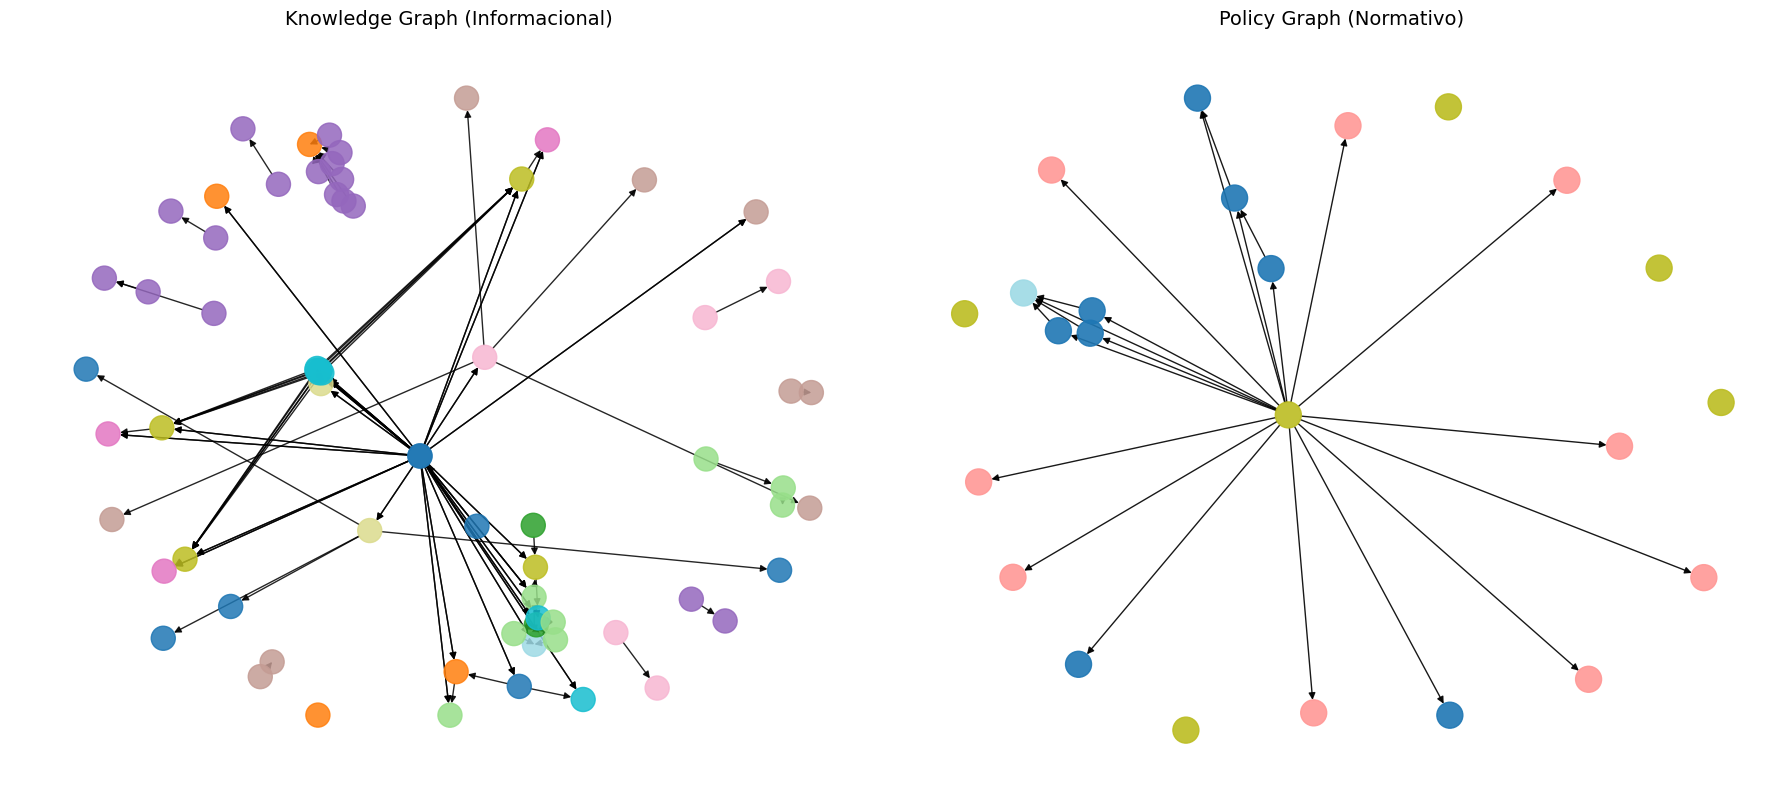

In [120]:
visualizar_kg_vs_policy(kg, policy_graph)


## [8] Compilação Policy → Árvore com Subpolicies

Compila Policy Graph em árvore JSON com ramificação por subpolicies detectadas automaticamente.

**Estratégia**:
1. Criar nó raiz roteador ("Qual o tipo de ocorrência?")
2. Para cada subpolicy: extrair subgrafo e compilar subárvore
3. Anexar subárvores como ramos da raiz
4. Resultado: árvore com branching semântico, menor entropia

In [79]:
from typing import Dict, Any, List, Tuple
import networkx as nx
import json

# 🔹 Utilitário: ordenar nós decisórios dentro da subpolicy

def ordenar_nos_decisao(subgraph: nx.DiGraph) -> List[str]:
    """
    Define ordem decisória dentro de uma subpolicy.
    Prioriza precedência estrutural (topological sort).
    """
    decision_nodes = [
        n for n, d in subgraph.nodes(data=True)
        if d.get("type") in {"Criterion", "Threshold"}
    ]

    decision_subgraph = subgraph.subgraph(decision_nodes)

    try:
        return list(nx.topological_sort(decision_subgraph))
    except nx.NetworkXUnfeasible:
        # Fallback: nós mais conectados primeiro
        return sorted(decision_nodes, key=lambda n: subgraph.degree(n), reverse=True)

#🔹 Construção recursiva de subnodos (mantida, mas agora com fluxo)

def construir_subnodos(
    policy: nx.DiGraph,
    node_id: str,
    visited: set = None,
    depth: int = 0,
    max_depth: int = 10
) -> List[Dict[str, Any]]:
    """
    Constrói subnodos recursivamente com encerramento local.
    """
    if visited is None:
        visited = set()

    if depth > max_depth or node_id in visited:
        return []

    visited.add(node_id)
    subnodos = []

    # 1️⃣ Encerramentos locais
    for succ in policy.successors(node_id):
        if policy.nodes[succ].get("type") == "Classification":
            subnodos.append({
                "id": succ.replace(':', '_').replace(' ', '_').lower(),
                "tipo": "terminal",
                "classe": policy.nodes[succ].get("id", "Classe não especificada")
            })

    # 2️⃣ Continuação do fluxo
    for succ in policy.successors(node_id):
        succ_type = policy.nodes[succ].get("type")

        if succ_type in {"Criterion", "Threshold"}:
            children = construir_subnodos(
                policy,
                succ,
                visited.copy(),
                depth + 1,
                max_depth
            )

            if not children:
                children = [{
                    "id": f"{succ}_default".replace(':', '_').replace(' ', '_').lower(),
                    "tipo": "terminal",
                    "classe": "Requer análise adicional"
                }]

            subnodos.append({
                "id": succ.replace(':', '_').replace(' ', '_').lower(),
                "pergunta": policy.nodes[succ].get("id", "Critério"),
                "tipo": "decisao",
                "subnodos": children
            })

    return subnodos
# 🔹 Compilação de uma subpolicy (CORRIGIDA)

def compilar_subarvore(policy_subgraph: nx.DiGraph, subpolicy_id: str) -> Dict[str, Any]:
    """
    Compila um subgrafo (subpolicy) em subárvore com ordem decisória explícita.
    """

    ordered_nodes = ordenar_nos_decisao(policy_subgraph)

    if not ordered_nodes:
        return {
            "id": subpolicy_id,
            "tipo": "terminal",
            "classe": "Subpolicy sem critérios executáveis"
        }

    root_node_id = ordered_nodes[0]
    root_data = policy_subgraph.nodes[root_node_id]

    subpolicy_root = {
        "id": subpolicy_id,
        "pergunta": root_data.get("id", f"Domínio normativo {subpolicy_id}"),
        "tipo": "decisao",
        "subnodos": construir_subnodos(
            policy_subgraph,
            root_node_id,
            visited=set(),
            depth=0
        )
    }

    if not subpolicy_root["subnodos"]:
        subpolicy_root["subnodos"].append({
            "id": f"{subpolicy_id}_terminal",
            "tipo": "terminal",
            "classe": "Requer análise técnica específica"
        })

    return subpolicy_root
#🔹 Compilador final com subpolicies (plug-and-play)

def compilar_arvore_com_subpolicies(
    policy: nx.DiGraph,
    communities: List[set]
) -> Dict[str, Any]:
    """
    Compila Policy Graph em árvore com ramificação automática por subpolicies.
    """

    raiz = {
        "id": "raiz",
        "pergunta": "Qual o tipo de ocorrência?",
        "tipo": "decisao",
        "subnodos": []
    }

    print(f"\n🌳 Compilando árvore com {len(communities)} subpolicies...\n")

    for i, community in enumerate(communities):
        subpolicy_id = f"subpolicy_{i}"

        nodes_in_subpolicy = set(community)

        # incluir classificações associadas
        for n in community:
            for succ in policy.successors(n):
                if policy.nodes[succ].get("type") == "Classification":
                    nodes_in_subpolicy.add(succ)

        subgraph = policy.subgraph(nodes_in_subpolicy).copy()

        print(f"   Subpolicy {i}:")
        print(f"      Nós: {subgraph.number_of_nodes()}")
        print(f"      Arestas: {subgraph.number_of_edges()}")

        subarvore = compilar_subarvore(subgraph, subpolicy_id)
        raiz["subnodos"].append(subarvore)

    if not raiz["subnodos"]:
        raiz["subnodos"].append({
            "id": "incidente_generico",
            "tipo": "terminal",
            "classe": "Classificação não determinada"
        })

    return raiz



## [7.5] Detecção Automática de Subpolicies

Utiliza expansão controlada baseada em **âncoras normativas** (IncidentType e Classification) para detectar subpolicies no Policy Graph.

**Abordagem**:
- **Âncoras Normativas**: Nós do tipo IncidentType e Classification servem como pontos de partida
- **Expansão Controlada**: Navegação bidirecional (predecessores + sucessores) com profundidade limitada
- **Evita Duplicação**: Subpolicies com pouca novidade (< 5 nós novos) são descartadas

**Objetivo**: Ramificar árvore por domínios normativos detectados automaticamente, reduzindo entropia.

In [80]:
#🔹 1. Preparar grafo para detecção de comunidades
print("\n🧠 Detectando subpolicies automaticamente...\n")

def detectar_ancoras_normativas(policy: nx.DiGraph):
    anchors = []

    for n, data in policy.nodes(data=True):
        if data.get("type") in ["IncidentType", "Classification"]:
            anchors.append(n)

    return anchors

def expandir_subpolicy(policy: nx.DiGraph, anchor: str, max_depth=5):
    visited = set()
    queue = [(anchor, 0)]
    subpolicy_nodes = set([anchor])

    while queue:
        node, depth = queue.pop(0)
        if depth >= max_depth:
            continue

        for succ in policy.successors(node):
            if succ not in visited:
                visited.add(succ)
                subpolicy_nodes.add(succ)
                queue.append((succ, depth + 1))

        for pred in policy.predecessors(node):
            if pred not in visited:
                visited.add(pred)
                subpolicy_nodes.add(pred)
                queue.append((pred, depth + 1))

    return subpolicy_nodes

anchors = detectar_ancoras_normativas(policy_graph)

subpolicies = []
used_nodes = set()

for i, anchor in enumerate(anchors):
    nodes = expandir_subpolicy(policy_graph, anchor)

    # Evitar subpolicies duplicadas
    if len(nodes - used_nodes) < 5:
        continue

    subpolicies.append(nodes)
    used_nodes |= nodes


🧠 Detectando subpolicies automaticamente...



In [81]:
#🔹 Execução + estatísticas

print("\n🌳 Compilando árvore de decisão com subpolicies...\n")

arvore_decisao = compilar_arvore_com_subpolicies(policy_graph, subpolicies)

with open(TREE_JSON, 'w', encoding='utf-8') as f:
    json.dump(arvore_decisao, f, ensure_ascii=False, indent=2)

print(f"\n✅ Árvore de decisão salva em: {TREE_JSON}")

def contar_nos_recursivo(node: Dict[str, Any]) -> Tuple[int, int]:
    if node.get("tipo") == "terminal":
        return 0, 1

    decisao, terminal = 1, 0
    for sub in node.get("subnodos", []):
        d, t = contar_nos_recursivo(sub)
        decisao += d
        terminal += t
    return decisao, terminal


num_decisao, num_terminal = contar_nos_recursivo(arvore_decisao)

print(f"\n📊 Estatísticas da Árvore (COM SUBPOLICIES):")
print(f"   Nós de decisão: {num_decisao}")
print(f"   Nós terminais: {num_terminal}")
print(f"   Total: {num_decisao + num_terminal}")
print(f"   Subpolicies (ramos principais): {len(subpolicies)}")


🌳 Compilando árvore de decisão com subpolicies...


🌳 Compilando árvore com 2 subpolicies...

   Subpolicy 0:
      Nós: 10
      Arestas: 9
   Subpolicy 1:
      Nós: 5
      Arestas: 4

✅ Árvore de decisão salva em: ../artifacts/anp_tree.json

📊 Estatísticas da Árvore (COM SUBPOLICIES):
   Nós de decisão: 3
   Nós terminais: 2
   Total: 5
   Subpolicies (ramos principais): 2


## [8] Compilação Policy → Árvore

Compila Policy Graph em árvore JSON compatível com classificador modular.

In [82]:
def compilar_arvore_decisao(policy: nx.DiGraph) -> Dict[str, Any]:
    """
    Compila Policy Graph em árvore de decisão JSON.
    
    Args:
        policy: Policy Graph (DAG)
        
    Returns:
        Árvore de decisão em formato JSON
    """
    # Encontrar roots (IncidentTypes sem predecessores)
    roots = [n for n in policy.nodes() 
            if policy.nodes[n]['type'] == 'IncidentType' 
            and policy.in_degree(n) == 0]
    
    if not roots:
        # Fallback: pegar todos IncidentTypes
        roots = [n for n in policy.nodes() if policy.nodes[n]['type'] == 'IncidentType']
    
    # Criar nó raiz "Qual o tipo de ocorrência?"
    raiz = {
        "id": "raiz",
        "pergunta": "Qual o tipo de ocorrência?",
        "tipo": "decisao",
        "subnodos": []
    }
    
    # Para cada IncidentType, criar subárvore
    for root_id in roots:
        root_data = policy.nodes[root_id]
        
        # Criar nó para este tipo de incidente
        incident_node = {
            "id": root_id.replace(':', '_').replace(' ', '_').lower(),
            "pergunta": root_data.get('id', 'Tipo de incidente'),
            "tipo": "decisao",
            "subnodos": []
        }
        
        # Construir subárvore a partir deste nó
        subnodos = construir_subnodos(policy, root_id)
        incident_node["subnodos"] = subnodos
        
        raiz["subnodos"].append(incident_node)
    
    # Se não houver roots, criar estrutura mínima
    if not raiz["subnodos"]:
        raiz["subnodos"].append({
            "id": "incidente_generico",
            "pergunta": "Incidente genérico",
            "tipo": "decisao",
            "subnodos": [
                {
                    "id": "classe_desconhecida",
                    "tipo": "terminal",
                    "classe": "Classificação não determinada"
                }
            ]
        })
    
    return raiz


def construir_subnodos(policy: nx.DiGraph, node_id: str, visited: set = None, depth: int = 0) -> List[Dict[str, Any]]:
    """
    Constrói subnodos recursivamente a partir de um nó.
    
    Args:
        policy: Policy Graph
        node_id: ID do nó atual
        visited: Conjunto de nós já visitados (evitar ciclos)
        depth: Profundidade atual (limitar recursão)
        
    Returns:
        Lista de subnodos
    """
    if visited is None:
        visited = set()
    
    # Limitar profundidade para evitar recursão infinita
    if depth > 10 or node_id in visited:
        return []
    
    visited.add(node_id)
    subnodos = []
    
    # Obter sucessores (ordenados por tipo de relação)
    successors = list(policy.successors(node_id))
    
    for succ_id in successors:
        succ_data = policy.nodes[succ_id]
        edge_data = policy[node_id][succ_id]
        
        # Se sucessor é Classification, criar nó terminal
        if succ_data['type'] == 'Classification':
            subnodos.append({
                "id": succ_id.replace(':', '_').replace(' ', '_').lower(),
                "tipo": "terminal",
                "classe": succ_data.get('id', 'Classe não especificada')
            })
        
        # Se sucessor é Criterion ou Threshold, criar nó de decisão
        elif succ_data['type'] in ['Criterion', 'Threshold']:
            # Construir pergunta
            pergunta = succ_data.get('id', 'Critério')
            
            # Recursivamente construir subnodos
            sub_subnodos = construir_subnodos(policy, succ_id, visited.copy(), depth + 1)
            
            # Se não houver subnodos, criar terminal padrão
            if not sub_subnodos:
                sub_subnodos = [{
                    "id": f"{succ_id}_default".replace(':', '_').replace(' ', '_').lower(),
                    "tipo": "terminal",
                    "classe": "Requer análise adicional"
                }]
            
            subnodos.append({
                "id": succ_id.replace(':', '_').replace(' ', '_').lower(),
                "pergunta": pergunta,
                "tipo": "decisao",
                "subnodos": sub_subnodos
            })
    
    return subnodos


# Compilar árvore
print("\n🌳 Compilando Policy Graph em árvore de decisão...\n")

arvore_decisao = compilar_arvore_decisao(policy_graph)

# Salvar árvore
with open(TREE_JSON, 'w', encoding='utf-8') as f:
    json.dump(arvore_decisao, f, ensure_ascii=False, indent=2)

print(f"✅ Árvore de decisão salva em: {TREE_JSON}")

# Estatísticas da árvore
def contar_nos_recursivo(node: Dict[str, Any]) -> Tuple[int, int]:
    """Conta nós de decisão e terminais recursivamente."""
    if node.get('tipo') == 'terminal':
        return 0, 1
    
    decisao = 1
    terminal = 0
    
    for subnode in node.get('subnodos', []):
        d, t = contar_nos_recursivo(subnode)
        decisao += d
        terminal += t
    
    return decisao, terminal

num_decisao, num_terminal = contar_nos_recursivo(arvore_decisao)

print(f"\n📊 Estatísticas da Árvore:")
print(f"   Nós de decisão: {num_decisao}")
print(f"   Nós terminais: {num_terminal}")
print(f"   Total: {num_decisao + num_terminal}")


🌳 Compilando Policy Graph em árvore de decisão...

✅ Árvore de decisão salva em: ../artifacts/anp_tree.json

📊 Estatísticas da Árvore:
   Nós de decisão: 2
   Nós terminais: 1
   Total: 3


## [9] Relatório de Qualidade

Gera estatísticas e visualizações sobre os artefatos criados.

In [83]:
print("\n" + "="*80)
print("📊 RELATÓRIO DE QUALIDADE")
print("="*80)

# 1. Corpus
print("\n1️⃣ CORPUS")
print(f"   Documentos processados: {len(clean_docs)}")
print(f"   Chunks gerados: {len(all_chunks)}")
print(f"   Média chunks/doc: {len(all_chunks) / len(clean_docs):.1f}")

# 2. Knowledge Graph
print("\n2️⃣ KNOWLEDGE GRAPH")
print(f"   Total de nós: {kg.number_of_nodes()}")
print(f"   Total de arestas: {kg.number_of_edges()}")
print(f"   Densidade: {nx.density(kg):.4f}")

print("\n   Distribuição de nós por tipo:")
for node_type, count in node_types.most_common():
    print(f"      {node_type}: {count}")

edge_types = Counter(kg[u][v]['type'] for u, v in kg.edges())
print("\n   Distribuição de arestas por tipo:")
for edge_type, count in edge_types.most_common():
    print(f"      {edge_type}: {count}")

# 3. Policy Graph
print("\n3️⃣ POLICY GRAPH")
print(f"   Total de nós: {policy_graph.number_of_nodes()}")
print(f"   Total de arestas: {policy_graph.number_of_edges()}")
print(f"   É DAG: {'✅' if nx.is_directed_acyclic_graph(policy_graph) else '❌'}")

if policy_graph.number_of_nodes() > 0:
    print("\n   Distribuição de nós por tipo:")
    for node_type, count in policy_node_types.most_common():
        print(f"      {node_type}: {count}")

# 3.5. Detecção de Subpolicies (Normativa-Semântica)
print("\n3️⃣.5️⃣ DETECÇÃO DE SUBPOLICIES (ÂNCORAS NORMATIVAS)")
print(f"   Subpolicies detectadas: {len(subpolicies)}")
print(f"   Âncoras encontradas: {len(anchors)}")

print("\n   Distribuição de tamanho das subpolicies:")
for i, sp in enumerate(subpolicies):
    print(f"      subpolicy_{i}: {len(sp)} nós")

# 4. Árvore de Decisão
print("\n4️⃣ ÁRVORE DE DECISÃO (COM SUBPOLICIES)")
print(f"   Nós de decisão: {num_decisao}")
print(f"   Nós terminais (classes): {num_terminal}")
print(f"   Subpolicies (ramos principais): {len(subpolicies)}")

# Profundidade média
def calcular_profundidade_media(node: Dict[str, Any], depth: int = 0) -> List[int]:
    """Calcula profundidades de todos os nós terminais."""
    if node.get('tipo') == 'terminal':
        return [depth]
    
    depths = []
    for subnode in node.get('subnodos', []):
        depths.extend(calcular_profundidade_media(subnode, depth + 1))
    
    return depths

depths = calcular_profundidade_media(arvore_decisao)
if depths:
    print(f"   Profundidade média: {sum(depths) / len(depths):.1f}")
    print(f"   Profundidade mínima: {min(depths)}")
    print(f"   Profundidade máxima: {max(depths)}")

# Fator de ramificação (branching factor) médio
def calcular_branching_factor(node: Dict[str, Any]) -> List[int]:
    """Calcula branching factor de todos os nós de decisão."""
    if node.get('tipo') == 'terminal':
        return []
    
    factors = [len(node.get('subnodos', []))]
    
    for subnode in node.get('subnodos', []):
        factors.extend(calcular_branching_factor(subnode))
    
    return factors

branching_factors = calcular_branching_factor(arvore_decisao)
if branching_factors:
    print(f"   Branching factor médio: {sum(branching_factors) / len(branching_factors):.1f}")
    print(f"   Branching factor máximo: {max(branching_factors)}")

# 5. Critérios mais centrais (por degree no Policy Graph)
if policy_graph.number_of_nodes() > 0:
    print("\n5️⃣ TOP 20 CRITÉRIOS MAIS CENTRAIS (por degree)")
    
    criterion_nodes_list = [n for n in policy_graph.nodes() if policy_graph.nodes[n]['type'] == 'Criterion']
    
    if criterion_nodes_list:
        degrees = [(n, policy_graph.degree(n)) for n in criterion_nodes_list]
        degrees.sort(key=lambda x: x[1], reverse=True)
        
        for i, (node_id, degree) in enumerate(degrees[:20], 1):
            node_name = policy_graph.nodes[node_id].get('id', node_id)
            print(f"   {i:2d}. {node_name[:50]:<50} (degree: {degree})")
    else:
        print("   Nenhum critério encontrado")

# 6. Exemplos de trilhas (paths)
print("\n6️⃣ EXEMPLOS DE TRILHAS (10 amostras aleatórias da raiz até folha)")

def gerar_trilhas_aleatorias(node: Dict[str, Any], path: List[str] = None, max_trilhas: int = 10) -> List[List[str]]:
    """Gera trilhas aleatórias da raiz até folhas."""
    if path is None:
        path = []
    
    path = path + [node.get('pergunta', node.get('classe', node.get('id', 'N/A'))[:50])]
    
    if node.get('tipo') == 'terminal':
        return [path]
    
    all_paths = []
    for subnode in node.get('subnodos', []):
        all_paths.extend(gerar_trilhas_aleatorias(subnode, path, max_trilhas))
        if len(all_paths) >= max_trilhas:
            break
    
    return all_paths[:max_trilhas]

trilhas = gerar_trilhas_aleatorias(arvore_decisao, max_trilhas=10)

for i, trilha in enumerate(trilhas, 1):
    print(f"\n   Trilha {i}:")
    for j, step in enumerate(trilha):
        indent = "   " * (j + 1)
        print(f"{indent}{'└─' if j == len(trilha) - 1 else '├─'} {step}")

print("\n" + "="*80)


📊 RELATÓRIO DE QUALIDADE

1️⃣ CORPUS
   Documentos processados: 2
   Chunks gerados: 43
   Média chunks/doc: 21.5

2️⃣ KNOWLEDGE GRAPH
   Total de nós: 48
   Total de arestas: 60
   Densidade: 0.0266

   Distribuição de nós por tipo:
      Classification: 17
      Criterion: 14
      Threshold: 7
      Incidenttype: 5
      Exception: 4
      Actor: 1

   Distribuição de arestas por tipo:
      CLASSIFIED_AS: 17
      APPLIES_TO: 13
      REQUIRES: 10
      IMPLIES: 9
      HAS_THRESHOLD: 8
      HAS_EXCEPTION: 3

3️⃣ POLICY GRAPH
   Total de nós: 49
   Total de arestas: 24
   É DAG: ✅

   Distribuição de nós por tipo:
      Criterion: 21
      Classification: 17
      Threshold: 7
      Exception: 4

3️⃣.5️⃣ DETECÇÃO DE SUBPOLICIES (ÂNCORAS NORMATIVAS)
   Subpolicies detectadas: 2
   Âncoras encontradas: 17

   Distribuição de tamanho das subpolicies:
      subpolicy_0: 10 nós
      subpolicy_1: 5 nós

4️⃣ ÁRVORE DE DECISÃO (COM SUBPOLICIES)
   Nós de decisão: 2
   Nós terminais (cla

## [10] Smoke Test Local

Valida a árvore JSON com um evento fictício de exemplo.

In [84]:
print("\n" + "="*80)
print("🧪 SMOKE TEST - Validação da Árvore")
print("="*80)

# Evento de exemplo
evento_exemplo = """
Vazamento de 15m³ de óleo diesel durante operação de abastecimento de embarcação.
Houve contaminação de solo e pequeno impacto em corpo hídrico próximo.
Nenhum trabalhador ferido. Operação de contenção realizada em 4 horas.
"""

print(f"\n📝 Evento de Exemplo:")
print(evento_exemplo)

print("\n🔍 Navegação Manual pela Árvore:\n")

# Função auxiliar para navegação
def navegar_arvore_manual(node: Dict[str, Any], level: int = 0):
    """Exibe estrutura da árvore para navegação manual."""
    indent = "  " * level
    
    if node.get('tipo') == 'terminal':
        print(f"{indent}🏁 TERMINAL: {node.get('classe', 'N/A')}")
        return
    
    print(f"{indent}❓ {node.get('pergunta', 'N/A')}")
    
    # Mostrar primeiras 3 opções
    for i, subnode in enumerate(node.get('subnodos', [])[:3], 1):
        print(f"{indent}   {i}. Opção: {subnode.get('pergunta', subnode.get('classe', subnode.get('id', 'N/A')))}")
    
    if len(node.get('subnodos', [])) > 3:
        print(f"{indent}   ... (mais {len(node['subnodos']) - 3} opções)")

# Exibir estrutura da raiz
print("RAIZ:")
navegar_arvore_manual(arvore_decisao)

# Simular seleção de caminho baseado no evento
print("\n🎯 Caminho Simulado (baseado no evento):")
print("\n1. Pergunta: 'Qual o tipo de ocorrência?'")
print("   Resposta: 'Acidente com Impacto no Meio Ambiente' (baseado em 'vazamento', 'contaminação')")

# Se houver subnodos, navegar pelo primeiro
if arvore_decisao.get('subnodos'):
    # Tentar encontrar nó relacionado a meio ambiente
    meio_ambiente_node = None
    for subnode in arvore_decisao['subnodos']:
        pergunta = subnode.get('pergunta', '').lower()
        if 'ambiente' in pergunta or 'meio' in pergunta:
            meio_ambiente_node = subnode
            break
    
    if not meio_ambiente_node:
        meio_ambiente_node = arvore_decisao['subnodos'][0]
    
    print(f"\n2. Nó selecionado: {meio_ambiente_node.get('pergunta', meio_ambiente_node.get('id'))}")
    
    if meio_ambiente_node.get('subnodos'):
        print(f"   Próximas perguntas disponíveis:")
        for i, sub in enumerate(meio_ambiente_node['subnodos'][:3], 1):
            print(f"      {i}. {sub.get('pergunta', sub.get('classe', 'N/A'))}")

print("\n✅ Validação da estrutura JSON:")
print("   - Raiz possui campo 'id': ✅" if 'id' in arvore_decisao else "   - Raiz FALTA campo 'id': ❌")
print("   - Raiz possui campo 'pergunta': ✅" if 'pergunta' in arvore_decisao else "   - Raiz FALTA 'pergunta': ❌")
print("   - Raiz possui campo 'tipo': ✅" if 'tipo' in arvore_decisao else "   - Raiz FALTA 'tipo': ❌")
print("   - Raiz possui 'subnodos': ✅" if 'subnodos' in arvore_decisao else "   - Raiz FALTA 'subnodos': ❌")

# Validar estrutura recursivamente
def validar_estrutura(node: Dict[str, Any], path: str = "raiz") -> List[str]:
    """Valida estrutura da árvore recursivamente."""
    erros = []
    
    if 'id' not in node:
        erros.append(f"{path}: Falta campo 'id'")
    
    if 'tipo' not in node:
        erros.append(f"{path}: Falta campo 'tipo'")
    elif node['tipo'] == 'terminal':
        if 'classe' not in node:
            erros.append(f"{path}: Nó terminal sem campo 'classe'")
    elif node['tipo'] == 'decisao':
        if 'pergunta' not in node:
            erros.append(f"{path}: Nó de decisão sem campo 'pergunta'")
        if 'subnodos' not in node:
            erros.append(f"{path}: Nó de decisão sem campo 'subnodos'")
        else:
            for i, subnode in enumerate(node['subnodos']):
                erros.extend(validar_estrutura(subnode, f"{path}/subnodo[{i}]"))
    
    return erros

erros_estrutura = validar_estrutura(arvore_decisao)

if erros_estrutura:
    print("\n⚠️ Erros de estrutura encontrados:")
    for erro in erros_estrutura[:10]:  # Mostrar primeiros 10
        print(f"   - {erro}")
    if len(erros_estrutura) > 10:
        print(f"   ... (mais {len(erros_estrutura) - 10} erros)")
else:
    print("\n✅ Estrutura da árvore válida!")

print("\n" + "="*80)


🧪 SMOKE TEST - Validação da Árvore

📝 Evento de Exemplo:

Vazamento de 15m³ de óleo diesel durante operação de abastecimento de embarcação.
Houve contaminação de solo e pequeno impacto em corpo hídrico próximo.
Nenhum trabalhador ferido. Operação de contenção realizada em 4 horas.


🔍 Navegação Manual pela Árvore:

RAIZ:
❓ Qual o tipo de ocorrência?
   1. Opção: Incidente genérico

🎯 Caminho Simulado (baseado no evento):

1. Pergunta: 'Qual o tipo de ocorrência?'
   Resposta: 'Acidente com Impacto no Meio Ambiente' (baseado em 'vazamento', 'contaminação')

2. Nó selecionado: Incidente genérico
   Próximas perguntas disponíveis:
      1. Classificação não determinada

✅ Validação da estrutura JSON:
   - Raiz possui campo 'id': ✅
   - Raiz possui campo 'pergunta': ✅
   - Raiz possui campo 'tipo': ✅
   - Raiz possui 'subnodos': ✅

✅ Estrutura da árvore válida!



## 📦 Resumo dos Artefatos Gerados

Todos os artefatos foram salvos em `artifacts/`:

1. **`anp_text_corpus.jsonl`** - Corpus de textos limpos (um documento por linha)
2. **`anp_kg.graphml`** - Knowledge Graph completo (formato GraphML)
3. **`anp_kg.json`** - Knowledge Graph completo (formato JSON)
4. **`anp_policy.graphml`** - Policy Graph decisório (formato GraphML)
5. **`anp_policy.json`** - Policy Graph decisório (formato JSON)
6. **`anp_tree.json`** - Árvore de decisão final (compatível com classificador)

### Próximos Passos

1. **Validação manual**: Revisar `anp_tree.json` para garantir coerência normativa
2. **Refinamento do KG**: Ajustar prompt guia e reprocessar chunks com melhor qualidade
3. **Integração com LATS**: Carregar `anp_tree.json` no classificador LATS-P
4. **Expansão de classes**: Adicionar mais informações normativas aos nós terminais
5. **Teste com eventos reais**: Validar árvore com casos de uso da ANP

### Notas Importantes

- ⚠️ **MODO DE TESTE ATIVO**: Apenas 10 chunks foram processados. Para produção, altere `TEST_MODE = False`
- 💰 **Custo de API**: Processar corpus completo pode custar significativamente em tokens Azure OpenAI
- 🔄 **Reexecução**: Notebook é idempotente - pode ser reexecutado para regenerar artefatos
- 📊 **Qualidade**: Qualidade final depende da qualidade dos PDFs e do prompt guia

In [85]:
# Exibir localização dos artefatos
print("\n📦 ARTEFATOS GERADOS:\n")
print(f"   📄 Corpus:        {CORPUS_FILE}")
print(f"   🕸️  KG (GraphML):  {KG_GRAPHML}")
print(f"   🕸️  KG (JSON):     {KG_JSON}")
print(f"   🎯 Policy (GraphML): {POLICY_GRAPHML}")
print(f"   🎯 Policy (JSON):    {POLICY_JSON}")
print(f"   🌳 Árvore (JSON):    {TREE_JSON}")
print("\n✅ Pipeline completo!")


📦 ARTEFATOS GERADOS:

   📄 Corpus:        ../artifacts/anp_text_corpus.jsonl
   🕸️  KG (GraphML):  ../artifacts/anp_kg.graphml
   🕸️  KG (JSON):     ../artifacts/anp_kg.json
   🎯 Policy (GraphML): ../artifacts/anp_policy.graphml
   🎯 Policy (JSON):    ../artifacts/anp_policy.json
   🌳 Árvore (JSON):    ../artifacts/anp_tree.json

✅ Pipeline completo!
